In [1]:
%%capture 
!pip install wandb[aws]

# W&B Artifact

Use Weights & Biases Artifacts to track datasets, models, dependencies, and results through each step of your machine learning pipeline. Artifacts make it easy to get a complete and auditable history of changes to your files.
Artifacts can be thought of as a versioned directory. Artifacts are either an input of a run or an output of a run. Common artifacts include entire training sets and models. Store datasets directly into artifacts, or use artifact references to point to data in other systems like Amazon S3, GCP, or your own system.

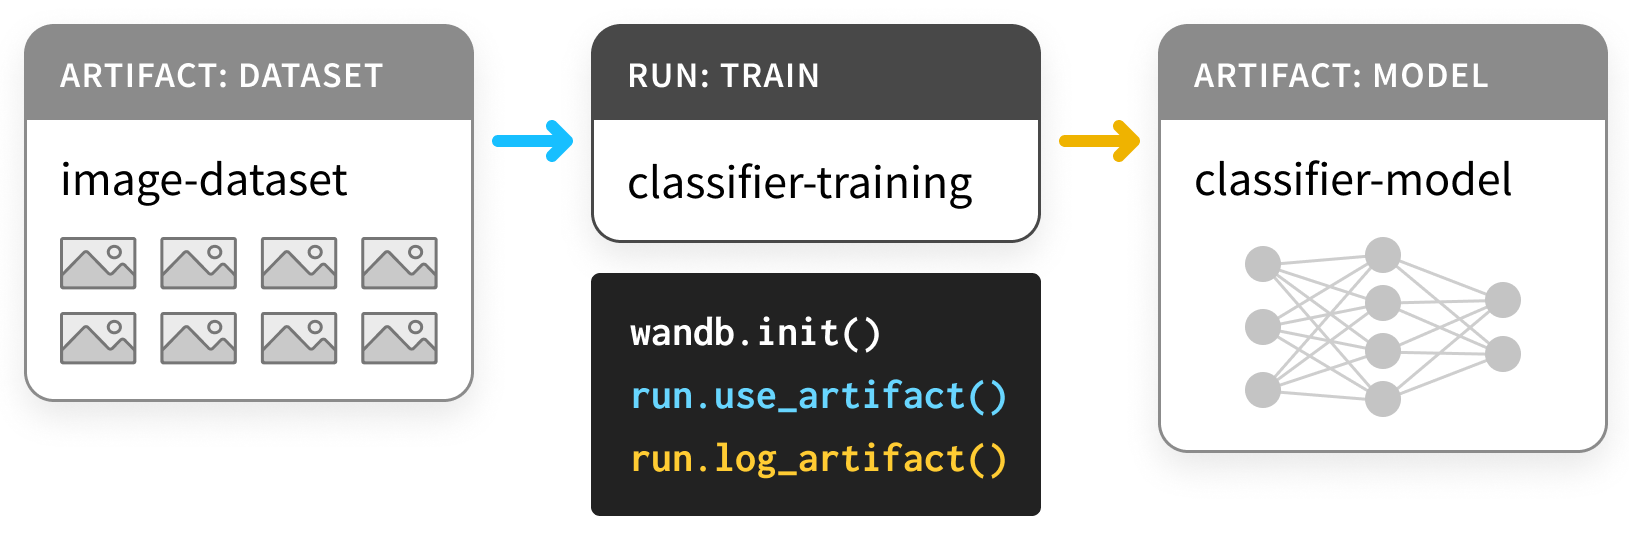

# Getting Started

Logging artifacts to W&B requires an active experiment.  But we can create the Artifact before or during the experiment!  The thing to keep in mind is that we must actually `log_artifact` before the experiment concludes.  

When we start to create an Artifact, we must provide the following 
* `name` 
* `type` 

and we may provide 
* `description`
* `metadata`

Usage might look like 

```
run = wandb.init(project = "my-project")
artifact = wandb.Artifact(name = "my_artifact", type = "data")
artifact.add_file("/path/to/my/file.txt")
run.log_artifact(artifact)
run.finish()
```

Along with `add_file` we also provide the following methods
* `add_dir` - Adds a local directory to the artifact.
* `add_reference` - Adds a reference denoted by a URI to the artifact. Unlike adding files or directories,
references are NOT uploaded to W&B. However, artifact methods such as `download()` can
be used regardless of whether the artifact contains references or uploaded files.
* `add` - add an W&B object to W&B Artifact.  supported objects include: ImageMasks, Audio, Image, Video, Tables


There are some other patterns of usage that are less common, for example 
```
import wandb 
artifact = wandb.Artifact(name = "my-data", type = "dataset")
with artifact.new_file("my_data.txt", mode="w") as file:
        file.write("some text")
run = wandb.init("artifact-ex")
run.log_artifact(artifact) 
run.finish()
```

In [2]:
import os 
import wandb
import pandas as pd
os.environ["WANDB_PROJECT"] = "artifact-training"

## Using `add_dir` and `add_file`

In [3]:
with wandb.init() as run:
  print(run.config)
  artifact = wandb.Artifact(name = "colab-datasets", type = "data")
  artifact.add_dir("/content/sample_data")
  run.log_artifact(artifact)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Adding directory to artifact (/content/sample_data)... 

{}


Done. 0.4s


## using `add_reference`

Use reference artifacts to track files saved outside the Weights & Biases system, for example in an Amazon S3 bucket, GCS bucket, HTTP file server, or even an NFS share. 

Weights & Biases Artifacts support any Amazon S3 compatible interface — including MinIO!

Weights & Biases will attempt to use the corresponding credential files or environment variables associated with the cloud provider when it adds references to Amazon S3 or GCS buckets.

In [4]:
import wandb
import os 
os.environ["AWS_ACCESS_KEY_ID"] = ''
os.environ["AWS_SECRET_ACCESS_KEY"] = ''

In [5]:
with wandb.init() as run:
  print(run.config)
  artifact = wandb.Artifact(name = "referneces", type = "ref-artifact")
  artifact.add_reference("https://s3.amazonaws.com/bmxwebserverprod/attachments/485759/2023_Rulebook.pdf")
  artifact.add_reference("s3://tim-w-hackathon/name")
  run.log_artifact(artifact)

wandb: Currently logged in as: tim-w. Use `wandb login --relogin` to force relogin


{}


wandb: Generating checksum for up to 10000 objects with prefix "name"... Done. 0.1s


In [6]:
artifact.wait()
for k, v in artifact.manifest.entries.items():
  print(f"filename: {k}, reference: {v.ref}")

filename: 2023_Rulebook.pdf, reference: https://s3.amazonaws.com/bmxwebserverprod/attachments/485759/2023_Rulebook.pdf
filename: ofyour/folders/README.md, reference: s3://tim-w-hackathon/name/ofyour/folders/README.md


## Using `add` method

Not as common.  `add` is reserved for W&B data types.  

In [7]:
wandb.init()
df = pd.read_json("sample_data/anscombe.json")
artifact = wandb.Artifact('my_table', 'dataset')
table = wandb.Table(dataframe = df)
artifact.add(table, "anscombe")
wandb.log_artifact(artifact)
wandb.finish()

# Using Artifacts

Using artifacts in an experiment, you will always employ the following pattern

* initialize the run 
* use the `run.use_artifact` method

`use_artifact` returns a `wandb.Artifact`.  From here, you will either use the artifact's `get` method or the `download` method

In [8]:
with wandb.init() as run:
  artifact = run.use_artifact(f"{run.entity}/{run.project}/referneces:latest", type = "ref-artifact")
  local_artifact_path = artifact.download()

wandb:   2 of 2 files downloaded.  


In [19]:
run

In [10]:
## artifacts containing W&B data types
wandb.init()
artifact = wandb.use_artifact('my_table:latest')
tbl = artifact.get("anscombe")
wandb.finish()
df = pd.DataFrame(tbl.data, columns = tbl.columns)
df.head(10)

wandb:   1 of 1 files downloaded.  


,Series,X,Y
0,I,10,8.04
1,I,8,6.95
2,I,13,7.58
3,I,9,8.81
4,I,11,8.33
5,I,14,9.96
6,I,6,7.24
7,I,4,4.26
8,I,12,10.84
9,I,7,4.81


# Sweeps + Artifacts + Model Registry

In [11]:
%%capture
!pip install -q pytorch-lightning

The following code, grabs MNISt data and specifies defines a class extending `pytorch_lightning.LightningModule`.  

In [12]:
from torch.optim import SGD
from torch.optim import Adagrad
import torch
from torch.nn import Linear, CrossEntropyLoss, functional as F
from torch.optim import Adam
from torchmetrics.functional import accuracy
from pytorch_lightning import LightningModule
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import os
import glob
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks import ModelCheckpoint

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))])

dataset = MNIST(root="./MNIST", download=True, transform=transform)
training_set, validation_set = random_split(dataset, [55000, 5000])

class MNIST_LitModule(LightningModule):

    def __init__(self, n_classes=10, n_layer_1=128, n_layer_2=256, lr=1e-3, optim = "Adam"):
        '''method used to define our model parameters'''
        super().__init__()

        # mnist images are (1, 28, 28) (channels, width, height)
        self.layer_1 = Linear(28 * 28, n_layer_1)
        self.layer_2 = Linear(n_layer_1, n_layer_2)
        self.layer_3 = Linear(n_layer_2, n_classes)

        # loss
        self.loss = CrossEntropyLoss()

        # optimizer parameters
        self.lr = lr

        # save hyper-parameters to self.hparams (auto-logged by W&B)
        self.save_hyperparameters()

        self.optim = optim

    def forward(self, x):
        '''method used for inference input -> output'''

        batch_size, channels, width, height = x.size()

        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(batch_size, -1)

        # let's do 3 x (linear + relu)
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = F.relu(x)
        x = self.layer_3(x)

        return x

    def training_step(self, batch, batch_idx):
        '''needs to return a loss from a single batch'''
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        self.log('train_loss', loss)
        self.log('train_accuracy', acc)

        return loss

    def validation_step(self, batch, batch_idx):
        '''used for logging metrics'''
        preds, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        self.log('val_loss', loss)
        self.log('val_accuracy', acc)

        # Let's return preds to use it in a custom callback
        return preds

    def test_step(self, batch, batch_idx):
        '''used for logging metrics'''
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        self.log('test_loss', loss)
        self.log('test_accuracy', acc)
    
    def configure_optimizers(self):
        '''defines model optimizer'''
        if self.optim == "Adam":
          return Adam(self.parameters(), lr=self.lr)
        elif self.optim == "SGD":
          return SGD(self.parameters(), lr = self.lr)
        elif self.optim == "Adagrad":
          return Adagrad(self.parameters(), lr = self.lr)
    
    def _get_preds_loss_accuracy(self, batch):
        '''convenience function since train/valid/test steps are similar'''
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.loss(logits, y)
        acc = accuracy(preds=preds, target=y, task="multiclass", num_classes=10)
        return preds, loss, acc

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



In what follows, we will define a sweep configuration as well as run a sweep.  

As the sweep is conducted, each run in the sweep will be logging checkpoints to W&B.  Afterwards, we will grab the best run and log the latest checkpoint to the W&B Model Registry

In [13]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

sweep_config = {
  'method': 'random', 
  'metric': {
      'name': 'val_loss',  ## matches what i write via SummaryWriter
      'goal': 'minimize'
  },
  'early_terminate':{
      'type': 'hyperband',
      'min_iter': 5
  },
  'parameters': {
      'learning_rate':{
          'values': [0.05,0.025,0.01,0.005,0.001]
      }, 
      'batch_size': { 
          'values': [128, 256]
      }
  }
}

def sweep_train(config_defaults = dict(learning_rate=0.01, batch_size = 128)): 

  config_standard = {
          "num_workers": os.cpu_count(),  # try 0, 1, and 2
          "pin_memory": True,  # try False and True
          "precision": 32,  # try 16 and 32
          "optimizer": "Adam", 
          }
  
  config = {**config_defaults, **config_standard}
  wandb.init(config = config)
  wandb_logger = WandbLogger(log_model='all', save_code=True, config=config)

  class LogPredictionsCallback(Callback):
      
      def on_validation_batch_end(
          self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
          """Called when the validation batch ends."""
  
          # `outputs` comes from `LightningModule.validation_step`
          # which corresponds to our model predictions in this case
          
          # Let's log 20 sample image predictions from first batch
          if batch_idx == 0:
              n = 20
              x, y = batch
              images = [img for img in x[:n]]
              captions = [f'Ground Truth: {y_i} - Prediction: {y_pred}' for y_i, y_pred in zip(y[:n], outputs[:n])]
              
              # Option 1: log images with `WandbLogger.log_image`
              wandb_logger.log_image(key='sample_images', images=images, caption=captions)

              # Option 2: log predictions as a Table
              columns = ['image', 'ground truth', 'prediction']
              data = [[wandb.Image(x_i), y_i, y_pred] for x_i, y_i, y_pred in list(zip(x[:n], y[:n], outputs[:n]))]
              wandb_logger.log_table(key='sample_table', columns=columns, data=data)  

  log_predictions_callback = LogPredictionsCallback()
  checkpoint_callback = ModelCheckpoint(monitor='val_accuracy', mode='max')

  training_loader = DataLoader(training_set, batch_size=wandb.config.batch_size, shuffle=True, pin_memory=True)
  validation_loader = DataLoader(validation_set, batch_size=64, pin_memory=True)
  ## Using a raw DataLoader, rather than LightningDataModule, for greater transparency

  # Set up model
  model = MNIST_LitModule(n_layer_1=128, n_layer_2=128, optim = wandb.config.optimizer, lr = wandb.config.learning_rate)
  wandb.watch(model)


  trainer = Trainer(gpus = 1, max_epochs=5,logger=wandb_logger,
                            callbacks=[
                                      checkpoint_callback, 
                                      log_predictions_callback
                                      ], 
                        precision=32)
  trainer.fit(model, training_loader, validation_loader)
  wandb.finish()

In [14]:
sweep_id = wandb.sweep(sweep_config)

wandb_agent = wandb.agent(sweep_id, function=sweep_train, count = 10)

Create sweep with ID: 9pjrw1nn
Sweep URL: https://wandb.ai/tim-w/artifact-training/sweeps/9pjrw1nn


wandb: Agent Starting Run: 0uderkir with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/loggers/wandb.py:319: UserWarning: Providing log_model=all requires wandb version >= 0.10.22 for logging associated model metadata.
Hint: Upgrade with `pip install --upgrade wandb`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_accuracy,▃▄▁▅▂▅▅▇▇▃▅▆▄▆▇▇▅▅▅▆▆█▇▇▄▄▅▇▆▃▆▅▇▄▅▆▇▆▄▅
train_loss,▇▄█▂▇▄▃▂▂▄▄▁▇▁▅▂▆▄▅▃▂▁▁▃▅▆▃▂▃▇▂▄▅█▃▃▄▄▅▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
val_accuracy,▇█▃▁▇
val_loss,▁▁▄█▁
epoch,4
train_accuracy,0.64773
train_loss,0.86368
trainer/global_step,2149
val_accuracy,0.6876


wandb: Agent Starting Run: fcavgwv1 with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.025
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ./lightning_logs/version_None/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params
---------------------------------------------
0 | layer_1 | Linear           | 100 K 
1 | layer_2 | Linear           | 16.5 K
2 | layer_3 | Linear           | 1.3 K 
3 | loss    | CrossEntropyLoss | 0     
-----------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_accuracy,▁▆▅▄▅▆▅▄▇▄▄▇▅▅▅▆▄▆▅▅▄▇▆▅▇▇█▅▇▆▅▇▆▇▄▇▄▄▇▁
train_loss,▅▂▂▅▂▂▂▄▂▄█▃▁▃▄▅▆▄▂▃▄▂▃▄▂▂▃▄▁▂▅▃▂▁▄▂▄▄▂▅
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
val_accuracy,▁▅▃▆█
val_loss,█▃▄▃▁
epoch,4
train_accuracy,0.86364
train_loss,0.38582
trainer/global_step,2149
val_accuracy,0.9414


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0apov5w6 with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params
---------------------------------------------
0 | layer_1 | Linear           | 100 K 
1 | layer_2 | Linear           | 16.5 K
2 | layer_3 | Linear           | 1.3 K 
3 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.473     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_accuracy,▁▄▆▂▆▅▄▆▄▅▄▅▇▆▅▅▆▇▆▆▅▅▅▆▇▅▇▆▆▆▆▃▆▇▇▇▅▆██
train_loss,█▄▂▇▃▃▆▄▄▄▅▄▂▃▄▆▃▂▂▂▅▃▄▂▂▄▂▃▂▄▂▆▂▂▂▂▂▂▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
val_accuracy,▁▇▄██
val_loss,▇▁█▂▂
epoch,4
train_accuracy,0.98864
train_loss,0.08268
trainer/global_step,2149
val_accuracy,0.9612


wandb: Agent Starting Run: j4qs1b0b with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params
---------------------------------------------
0 | layer_1 | Linear           | 100 K 
1 | layer_2 | Linear           | 16.5 K
2 | layer_3 | Linear           | 1.3 K 
3 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.473     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_accuracy,▁▃▄▅▃▇▅▅▇▇▇▇▇▇▅▇▆▇▇▆▆█▆▅▅▆▇▇▅▇▇▆▆▇▇▇▅█▆█
train_loss,█▄▆▃▄▂▄▃▂▂▂▁▃▂▄▂▂▂▂▂▃▁▃▃▄▂▂▁▃▂▁▂▂▃▂▂▄▁▃▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
val_accuracy,▁▅▇█▇
val_loss,█▄▁▂▂
epoch,4
train_accuracy,0.98864
train_loss,0.04156
trainer/global_step,2149
val_accuracy,0.9692


wandb: Agent Starting Run: hitnqwlx with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params
---------------------------------------------
0 | layer_1 | Linear           | 100 K 
1 | layer_2 | Linear           | 16.5 K
2 | layer_3 | Linear           | 1.3 K 
3 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.473     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_accuracy,▁▁▅▄▅▅▅▅▇▅▇▆▅▅▇▅▆▅▅▇▆▆▇▆▇█▇▇█▆▆█▆█▇▇█▆█▇
train_loss,█▇▄▅▅▄▄▄▂▄▃▄▄▃▂▃▂▃▄▂▂▂▂▄▂▁▂▂▁▂▂▂▂▁▁▂▁▃▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
val_accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
epoch,4
train_accuracy,0.97727
train_loss,0.08813
trainer/global_step,2149
val_accuracy,0.9748


wandb: Agent Starting Run: z0ay26q6 with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params
---------------------------------------------
0 | layer_1 | Linear           | 100 K 
1 | layer_2 | Linear           | 16.5 K
2 | layer_3 | Linear           | 1.3 K 
3 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.473     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆█████
train_accuracy,▁▃▄▆▅▆▆▆▇█▆▇▆███▇▇▇▇█
train_loss,▆█▄▃▃▄▃▃▂▂▃▂▃▁▂▁▃▂▃▃▂
trainer/global_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
val_accuracy,▁▅▇▇█
val_loss,█▄▂▁▁
epoch,4
train_accuracy,0.89062
train_loss,0.44626
trainer/global_step,1074
val_accuracy,0.893


wandb: Agent Starting Run: j1ijtqt7 with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.025
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params
---------------------------------------------
0 | layer_1 | Linear           | 100 K 
1 | layer_2 | Linear           | 16.5 K
2 | layer_3 | Linear           | 1.3 K 
3 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.473     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆█████
train_accuracy,▁▃▄▄▃▃▄▇▃▄▅▆▆█▅▃▃▅▅▄▄
train_loss,█▄▅▄▄▅▄▁▅▅▃▂▂▁▃▇▃▂▄▃▄
trainer/global_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
val_accuracy,▂█▃▇▁
val_loss,▄▂▅▁█
epoch,4
train_accuracy,0.93359
train_loss,0.22483
trainer/global_step,1074
val_accuracy,0.936


wandb: Agent Starting Run: zts19rj5 with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params
---------------------------------------------
0 | layer_1 | Linear           | 100 K 
1 | layer_2 | Linear           | 16.5 K
2 | layer_3 | Linear           | 1.3 K 
3 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.473     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆█████
train_accuracy,▁▄▆▅▆▆▆▄█▆▇▇▇▆▇▇▆█▆▇▇
train_loss,█▆▃▅▄▃▃▇▂▂▃▂▁▃▁▁▄▂▄▁▂
trainer/global_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
val_accuracy,▁▅▆█▇
val_loss,█▅▂▁▂
epoch,4
train_accuracy,0.97266
train_loss,0.06584
trainer/global_step,1074
val_accuracy,0.9632


wandb: Agent Starting Run: wlkybt5v with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params
---------------------------------------------
0 | layer_1 | Linear           | 100 K 
1 | layer_2 | Linear           | 16.5 K
2 | layer_3 | Linear           | 1.3 K 
3 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.473     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆█████
train_accuracy,▂▂▁▂▄▃▁▇▅▄▇▅█▇▆▂▅▆▆▅█
train_loss,█▆█▆▅▅▆▃▄▃▂▄▁▂▂▅▄▂▂▃▁
trainer/global_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
val_accuracy,▁▄▇█▇
val_loss,▇▄▂▁█
epoch,4
train_accuracy,0.99609
train_loss,0.01507
trainer/global_step,1074
val_accuracy,0.9678


wandb: Agent Starting Run: tq3tk2zf with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params
---------------------------------------------
0 | layer_1 | Linear           | 100 K 
1 | layer_2 | Linear           | 16.5 K
2 | layer_3 | Linear           | 1.3 K 
3 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.473     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆█████
train_accuracy,▁▃▂▅▅▆▃▇▆▇▆▅▆▇▇█▆▇█▇▆
train_loss,█▇▇▄▄▃▅▃▄▂▂▃▃▃▂▁▂▂▁▂▂
trainer/global_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,4
train_accuracy,0.97266
train_loss,0.09957
trainer/global_step,1074
val_accuracy,0.9694
